<a href="https://colab.research.google.com/github/stogaja/ANPR/blob/main/2_License_Plate_Detection_(using_YOLOv3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# License Plate Detection using YOLOv3
YOLO abbreviates to You Only Look Once depicting its ability to detect objects and entities by using CNN (Convolutional Neural Network).Neural Network in YOLO uses weights trained by the user through annotated training data by using bounding boxes. Hence YOLO takes an image as input puts it through a Neural Network and gives the output in the image through bounding boxes.

## Importing necessary libraries

In [1]:
# dependencies

from IPython.display import Image
from matplotlib import pyplot as plt

import cv2
import argparse
import sys
import numpy as np
import pandas as pd
import os.path

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import adam_v2

In [2]:
# let's mount drive
from google.colab import drive
drive.mount('/content/drive')

# specifying the folder
os.chdir('/content/drive/My Drive/CORE/Neural-Network-Project/Neural-Networks-Project/Number-Plate-Detection')

Mounted at /content/drive


### If you want to test your own image , simply add the path of the image in the input_path variable, add 'r' before the path so it will be treated as raw string
#### For Example: input_path = r'path_to_image_folder/image.jpg'

In [3]:
#Enter path for the image to be tested
input_path = r'images/Indian-Number-Plates/car123.jpeg'

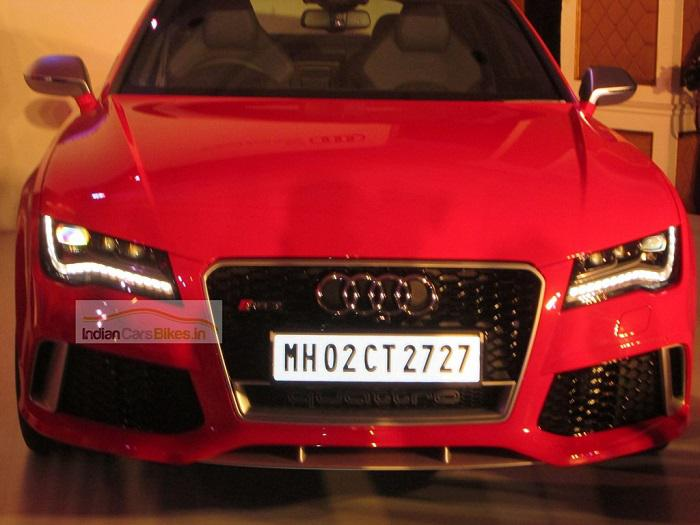

In [20]:
Image(input_path)

## Input Receiver

In [21]:
#Open the image file
cap = cv2.VideoCapture(input_path)

## YOLO Plate Detection
### Initialize the parameters

In [22]:
# Initialize the parameters

confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4  #Non-maximum suppression threshold

inpWidth = 416     #Width of network's input image
inpHeight = 416     #Height of network's input image

In [23]:
# Load names of classes
classesFile = "yolo_utils/classes.names";

In [24]:
# Append all different classes into the list 'classes'
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

In [25]:
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = r"yolo_utils/darknet-yolov3.cfg";
modelWeights = r"yolo_utils/lapi.weights";

After importing the config and weights file, set up the model using ```cv2.dnn.readNetFromDarknet()``` function.

In [26]:
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

### Define the post processing functions

In [27]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

The following function ```drawPred()``` draws a bounding box in an image when attributes like class name, confidence, coordinates and the image itself is passed though it.

In [28]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom, frame):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv2.FILLED)
    #cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine),    (255, 255, 255), cv.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

The following function ```postprocess()``` removes the bounding boxes with low confidence when the image and ouput are passed as attributes.

In [29]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        #print("out.shape : ", out.shape)
        for detection in out:
            #if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            #if scores[classId]>confThreshold:
            confidence = scores[classId]
            '''if detection[4]>confThreshold:
                print(detection[4], " - ", scores[classId], " - th : ", confThreshold)
                print(detection)'''
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences.
    cropped=None
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        
        # calculate bottom and right
        bottom = top + height
        right = left + width
        
        #crop the plate out
        cropped = frame[top:bottom, left:right].copy()
        # drawPred
        drawPred(classIds[i], confidences[i], left, top, right, bottom, frame)
    if cropped is not None:
        return cropped

### Plate Detection
The following code snippet first creates a 4D blob from the image, sets input to the network, runs the forward pass to get output of the output layers and sends the image to the function ```postprocess()``` for removing low confidence boxes and drawing the predicted box.

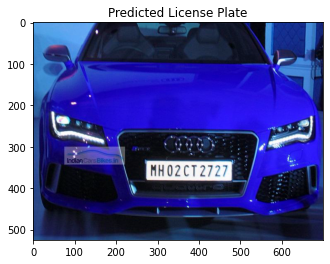

TypeError: ignored

In [30]:
while cv2.waitKey(1) < 0:

    hasFrame, frame = cap.read() #frame: an image object from cv2

    # Stop the program if reached end of video
    if not hasFrame:
        print("Done processing !!!")
        break

    # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))

    # Remove the bounding boxes with low confidence
    cropped = postprocess(frame, outs)

    plt.imshow(frame)
    plt.title("Predicted License Plate")
    plt.show()
    plt.imshow(cropped)
    plt.title("Cropped Image")
    plt.show()

## Character Segmentation
Character segmentation is an operation that seeks to decompose an image of a sequence of characters into subimages of individual symbols. It is one of the decision processes in a system for optical character recognition (OCR).

This phase contains the use of two functions: ```segment_characters()``` and ```find_contours()```.

In [15]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In the above function, we will be applying some more image processing to extract the individual characters from the license plate. The steps involved will be:
- Finding all the contours in the input image. The function cv2.findContours returns all the contours it finds in the image.
- After finding all the contours we consider them one by one and calculate the dimension of their respective bounding rectangle. Now consider bounding rectangle is the smallest rectangle possible that contains the contour. All we need to do is do some parameter tuning and filter out the required rectangle containing required characters. For this, we will be performing some dimension comparison by accepting only those rectangle that have:
  1. Width in the range 0, (length of the pic)/(number of characters) and,
  2. Length in a range of (width of the pic)/2, 4*(width of the pic)/5. After this step, we should have all the characters extracted as binary images.

In [16]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

The above function takes in the image as input and performs the following operation on it:
- Resizes it to a dimension such that all characters seem distinct and clear.
- Convert the colored image to a gray scaled image. We do this to prepare the image for the next process.
- Now the threshold function converts the grey scaled image to a binary image i.e each pixel will now have a value of 0 or 1 where 0 corresponds to black and 1 corresponds to white. It is done by applying a threshold that has a value between 0 and 255, here the value is 200 which means in the grayscaled image for pixels having a value above 200, in the new binary image that pixel will be given a value of 1. And for pixels having value below 200, in the new binary image that pixel will be given a value of 0.
- The image is now in binary form and ready for the next process Eroding. Eroding is a simple process used for removing unwanted pixels from the object’s boundary meaning pixels that should have a value of 0 but are having a value of 1.
- The image is now clean and free of boundary noise, we will now dilate the image to fill up the absent pixels meaning pixels that should have a value of 1 but are having value 0.
- The next step now is to make the boundaries of the image white. This is to remove any out of the frame pixel in case it is present.
- Next, we define a list of dimensions that contains 4 values with which we’ll be comparing the character’s dimensions for filtering out the required characters.
- Through the above processes, we have reduced our image to a processed binary image and we are ready to pass this image for character extraction.

In [17]:
char=segment_characters(cropped)

error: ignored

In [18]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

NameError: ignored

## Character Recognition using CNN
This phase has already been shown elaborately in this notebook: [1. License Plate Detection (using Contours)](https://github.com/pragatiunna/License-Plate-Number-Detection/blob/main/1.%20License%20Plate%20Detection%20(using%20Contours).ipynb). Please refer to this notebook first for understanding the implementation of the whole CNN model.

We'll now simply create an instance of the model and then import the saved weights.

In [19]:
# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('checkpoints/my_checkpoint')

## Predict the license plate number
We now have our license plate and the CNN model ready! We just need to predict each character using the model. For this, we'll first fix the dimension of each character image using the function ```fix_dimension```, in which it converts an image to a 3-channel image. The image can then be sent to ```model.predict_classes()``` in order to get the predicted character.

In [51]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = loaded_model.predict_classes(img)[0] #predicting the class
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

AttributeError: ignored

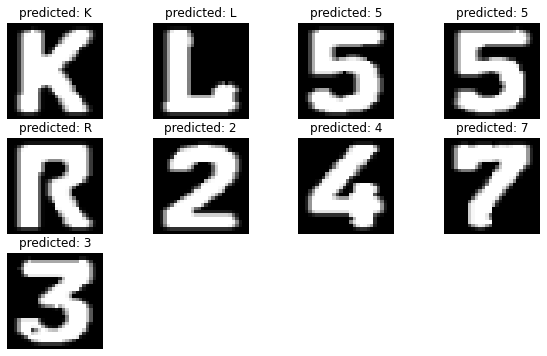

In [ ]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

## Importing the dataset
We'll now import our dataset to calculate the overall accuracy of this method. The dataset contains about 200 images with a labels.xlsx that will be useful to check if the predicted output is correct.

In [ ]:
labels=pd.read_excel('test_dataset/labels.xlsx')
labels['ID']=labels['ID'].map(str)
labels

,ID,NUMBER
0,1,KL55R2473
1,2,GJW115A1138
2,3,KL16J3636
3,4,MH20EE7598
4,5,PJJ1L76
...,...,...
181,182,DHF5B15
182,183,DBJ5R59
183,184,LVY8X45
184,185,YYD6B61


## Accuracy
We now need to run the whole code for all the images and calculate the accuracy.

In [ ]:
file_list=os.listdir(r"test_dataset/images")
count=0
for path in file_list:
#for entry in labels['ID']:
    input_path = 'test_dataset/images/'+path
    is_video = False
    no=path[:-4]
    row=labels['NUMBER'].where(labels['ID'] == no).dropna().values[0]
    
    cap = cv2.VideoCapture(input_path)
    
    outputFile = input_path + '_yolo_out_py.jpg'

    while cv2.waitKey(1) < 0:

        # get frame from the video
        hasFrame, frame = cap.read() #frame: an image object from cv2

        # Stop the program if reached end of video
        if not hasFrame:
            break

        # Create a 4D blob from a frame.
        try:
            blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
        except:
            break

        # Sets the input to the network
        net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = net.forward(getOutputsNames(net))

        # Remove the bounding boxes with low confidence
        cropped = postprocess(frame, outs)
        if cropped is not None:
            # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
            t, _ = net.getPerfProfile()
            label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
            
            char=segment_characters(cropped)
            # Predicting the output
            plate,count=show_results(count)
print("Accuracy: "+str((count/166)*100)+"%")

Accuracy: 74.09638554216868%
